In [1]:
import os
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2
import numpy as np
import tensorflow as tf

In [1870]:
def visualize_bounding_boxes(I, bounding_boxes, bounding_box_labels=None):
    '''
    This function takes a numpy image arry <I> and a list of
    <bounding_boxes> and displays I with bounding boxes. 
    Each element of <bounding boxes> is a 4-integer list 
    specifying the top left and bottom right corners of bounding 
    boxes contained in the image I. 
    '''
    fig, ax = plt.subplots()
    plt.imshow(I)
    idx = 0
    for [ul_x, ul_y, br_x, br_y] in bounding_boxes:
        (x, y) = (ul_x, ul_y)
        ax.plot(br_x, br_y, '.')
        rect = matplotlib.patches.Rectangle((x, y), abs(ul_x - br_x), abs(br_y - ul_y),
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        idx += 1
    plt.show()

In [1921]:
def detect_red_light(I):
    '''
    This function takes a numpy image array <I> and returns a list <bounding_boxes>.
    The list <bounding_boxes> should have one element for each red light in the 
    image. Each element of <bounding_boxes> should itself be a list, containing 
    four integers that specify a bounding box: the row and column index of the 
    top left corner and the row and column index of the bottom right corner (in
    that order). See the code below for an example.
    
    Note that PIL loads images in RGB order, so:
    I[:,:,0] is the red channel
    I[:,:,1] is the green channel
    I[:,:,2] is the blue channel
    '''
    
    bounding_boxes = [] # This should be a list of lists, each of length 4. See format example below. 
    
    '''
    BEGIN YOUR CODE
    '''    
    # Create traffic light kernels from images
    kernel_path = '/Users/Johanna/Desktop/Computer Vision/hw01/redlight_kernel.png'
    kernel1 = Image.open(kernel_path).convert(mode='RGB')
    kernel_path2 = '/Users/Johanna/Desktop/Computer Vision/hw01/redlight_kernel2.png'
    kernel2 = Image.open(kernel_path2).convert(mode='RGB')
    kernels = [kernel1]#[kernel1, kernel2]
    
    # Generate different sizes of kernels
    new_kernels = []
    for k in kernels:
        new_kernels.append(k)
        k_width, k_height = np.asarray(k).shape[0], np.asarray(k).shape[1]
        for maxsize in [50, 30, 20]:
            ratio = k_width/k_height
            ratio2 = k_height / k_width
            zoom_in_kernel = k.copy().resize((int(maxsize*ratio2), int(maxsize*ratio)))
            new_kernels.append(zoom_in_kernel)
    kernels = [np.asarray(k) for k in new_kernels]
    
    # Specify threshold for acceptable red lights
    thresholds = [0.2, 0.21, 0.2, 0.19] #[0.03, 0.075, 0.23, 0.4, 0.045, 0.04, 0.09, 0.08] 
    
    # Filter image with each kernel
    I_width, I_height = I.shape[1], I.shape[0]
    bounding_boxes = []
    r_vals = []
    for idx in range(len(kernels)):
        # Get kernel
        k = kernels[idx]
        k_height, k_width = k.shape[0], k.shape[1]
        # Normalize kernel
        k_normalized = normalize_image(k, I)
        # Define stride length
        stride = min(k_width, k_height)//5
        # Filter 2D image
        for ul_x in range(0, I_width-k_width, stride):
            for ul_y in range(0, I_height-k_height, stride):
                # Get patch from image
                br_x, br_y = (ul_x + k_width), (ul_y + k_height)
                I_patch = np.array(I[ul_y:br_y, ul_x:br_x])
                # normalize
                I_patch = normalize_image(I_patch, I)
                
                if I_patch.shape == k.shape:
                    # Convolve patch with kernel
                    r = np.mean(np.abs(np.subtract(I_patch.flatten(), k_normalized.flatten())))
                    
                    # Determine if patch passes threshold
                    if r < thresholds[idx]:
                        # Check that bounding box is not too close to other bounding box
                        flag = True
                        for [x1, y1, x2, y2] in bounding_boxes:
                            dist1 = np.sqrt((x1-ul_x)**2 + (y1-ul_y)**2)
                            dist2 = np.sqrt((x2-ul_x)**2 + (y2-ul_y)**2)
                            if dist1 < 100 or dist2 < 100:
                                flag = False
                
                        if flag:
                            r_vals.append(round(r, 5))
                            bounding_boxes.append([ul_x, ul_y, br_x, br_y])

    '''
    END YOUR CODE
    '''
    
    for i in range(len(bounding_boxes)):
        assert len(bounding_boxes[i]) == 4
    
    visualize_bounding_boxes(I, bounding_boxes, r_vals)
    return bounding_boxes

In [1909]:
def normalize_image(img, I):
    '''
    For an image patch or kernel, img, normalize it with respect to each color channel using
    the mean of each color channel of the full image, I. Return the normalized img.
    '''
    img_normalized = img.copy().astype(np.float)
    r, g, b = I[:, :, 0], I[:, :, 1], I[:, :, 2]
    img_normalized[:, :, 0] = np.subtract(img_normalized[:, :, 0], np.mean(r)) / 255 
    img_normalized[:, :, 1] = np.subtract(img_normalized[:, :, 1], np.mean(g)) / 255 
    img_normalized[:, :, 2] = np.subtract(img_normalized[:, :, 2], np.mean(b)) / 255 
    return img_normalized 

Image:  0


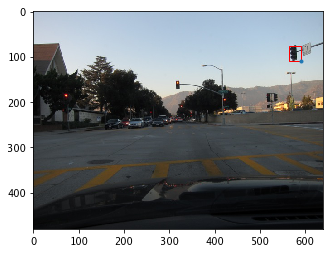

Image:  1


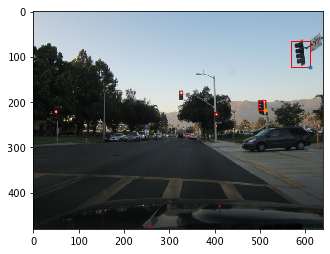

Image:  2


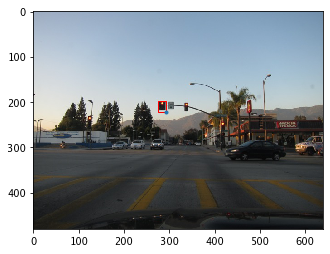

Image:  3


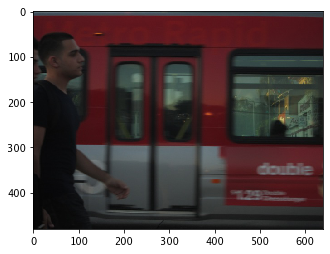

Image:  4


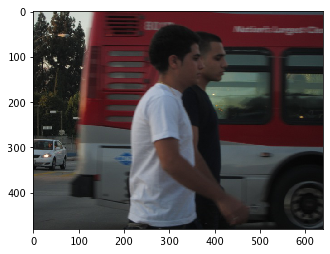

Image:  5


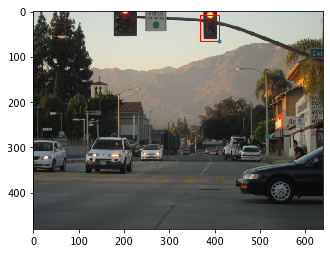

Image:  6


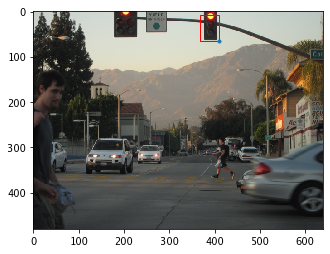

Image:  7


In [ ]:
# Download data
data_path = '/Users/Johanna/Desktop/Computer Vision/hw01/RedLights2011_Medium/'

# get sorted list of files: 
file_names = sorted(os.listdir(data_path)) 

# remove any non-JPEG files: 
file_names = [f for f in file_names if '.jpg' in f] 

# set a path for saving predictions: 
preds_path = '../data/hw01_preds' 
os.makedirs(preds_path,exist_ok=True) # create directory if needed 

preds = {}
idx = 0
for i in range(len(file_names)):
    print("Image: ", idx)
    idx += 1
    # read image using PIL:
    I = Image.open(os.path.join(data_path,file_names[i]))
    
    # convert to numpy array:
    I = np.asarray(I)
    
    preds[file_names[i]] = detect_red_light(I)
    
# save preds (overwrites any previous predictions!)
with open(os.path.join(preds_path,'preds.json'),'w') as f:
    json.dump(preds,f)

In [1922]:
'''Show easy or "good" image detection examples

This images have red traffic lights that are easy to detect, because (1) there is greater similarity
between the traffic lights and kernel, due to blue sky background, (2) the images do not contain
misleading objects, and (3) the traffic lights are large enough to provide enough pixel-wise 
similarity with the kernel.
'''
easy_indices = [9, 7, 60, 105]
for i in easy_indices:
    I = Image.open(os.path.join(data_path,file_names[i]))
    I = np.asarray(I)
    detect_red_light(I)

IndexError: list index out of range

In [1918]:
'''
Show hard or "bad" image examples

This images are hard, because (1) there is a lack of contrast between the traffic light and 
background, (2) the traffic lights are too far away (too small) to provid enough similarity
between the kernel and image pixels, and (3) there are similar objects that aren't traffic 
lights in the image.
'''
hard_indices = [19, 20, 191]
for i in hard_indices:
    I = Image.open(os.path.join(data_path,file_names[i]))
    I = np.asarray(I)
    detect_red_light(I)

KeyboardInterrupt: 